In [4]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import geometry_mask
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, precision_recall_curve
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(all_image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in all_image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(all_image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs, max_images=5):
    features = []
    labels = []
    image_name = []
    count = 0

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        if count >= max_images:
            break
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)
        count += 1

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
}) 

In [6]:
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Calculate and print the number of pixels for each class in the training and test datasets
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Calculate class distributions
print_class_distribution(train_df, "Training")
print_class_distribution(test_df, "Test")

# Calculate and print the number of pixels from each island in the test dataset
def print_island_distribution(df):
    islands = df['image_name'].apply(lambda x: extract_island_and_date(os.path.basename(x))[0])
    island_counts = islands.value_counts()
    print("\nTest Dataset Island Distribution:")
    for island, count in island_counts.items():
        print(f"{island}: {count}")

# Print image names used in the test data and the number of pixels from each island
def print_test_images_info(df):
    print("\nTest Dataset Image Names and Pixel Counts:")
    image_names = df['image_name'].unique()
    for image_name in image_names:
        image_pixel_count = (df['image_name'] == image_name).sum()
        print(f"Image: {os.path.basename(image_name)}, Pixels: {image_pixel_count}")

# Print island distribution and test images info
print_island_distribution(test_df)
print_test_images_info(test_df)



Training Class Distribution:
ocean: 295211
ice: 166330
freshwater: 27808
rock: 7433
walrus_mixed: 238
walrus_pure: 56

Test Class Distribution:
ocean: 73803
ice: 41582
freshwater: 6953
rock: 1858
walrus_mixed: 59
walrus_pure: 14

Test Dataset Island Distribution:
buch: 110759
moff: 13510

Test Dataset Image Names and Pixel Counts:
Image: buch_20230714_image.tif, Pixels: 23740
Image: buch_20230720_image.tif, Pixels: 37364
Image: buch_20230731_image.tif, Pixels: 34744
Image: buch_20230923_image.tif, Pixels: 14911
Image: moff_20230717_image.tif, Pixels: 13510


In [7]:
# Train and evaluate models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(kernel='linear', probability=True, random_state=42)
}

results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    
    # Save the model
    model_filename = f"{model_name.replace(' ', '_')}_model.joblib"
    joblib.dump(model, model_filename)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    results[model_name] = {
        "model": model,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "kappa": kappa,
        "conf_matrix": conf_matrix,
        "y_pred": y_pred
    }
    
    print(f"{model_name} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, Cohen's Kappa: {kappa}")

Training Random Forest...
Random Forest - Accuracy: 0.9839300227731775, Precision: 0.9835503916833953, Recall: 0.9839300227731775, F1 Score: 0.9835943407499248, Cohen's Kappa: 0.9697302839913281
Training XGBoost...


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.9814273873612889, Precision: 0.9810089233007432, Recall: 0.9814273873612889, F1 Score: 0.9811145602675531, Cohen's Kappa: 0.9650104062763801
Training SVM...
SVM - Accuracy: 0.9531983036799202, Precision: 0.9514557075609485, Recall: 0.9531983036799202, F1 Score: 0.946209966667605, Cohen's Kappa: 0.9103436640890418


C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


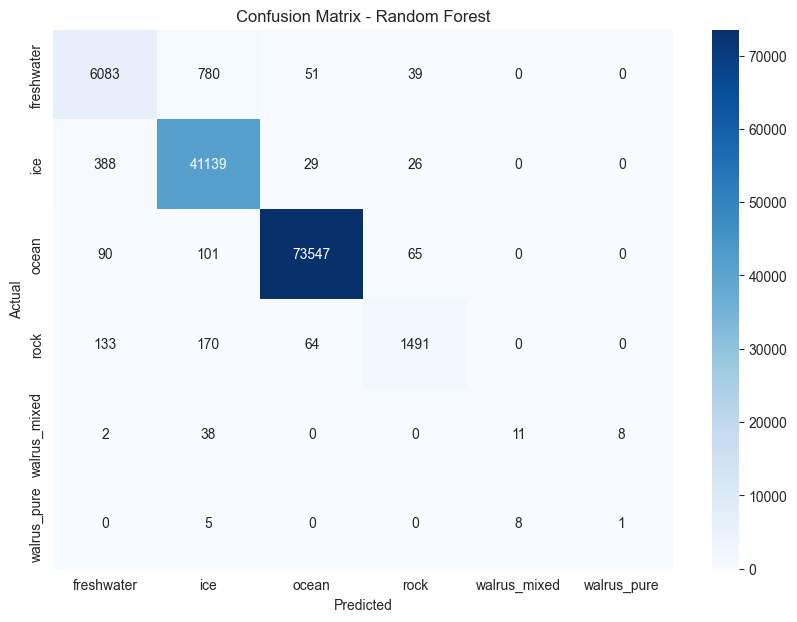

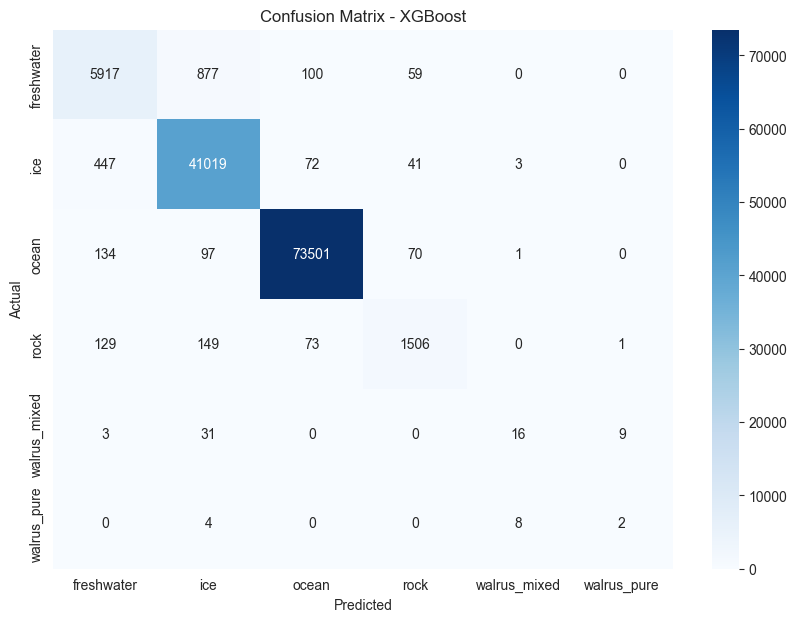

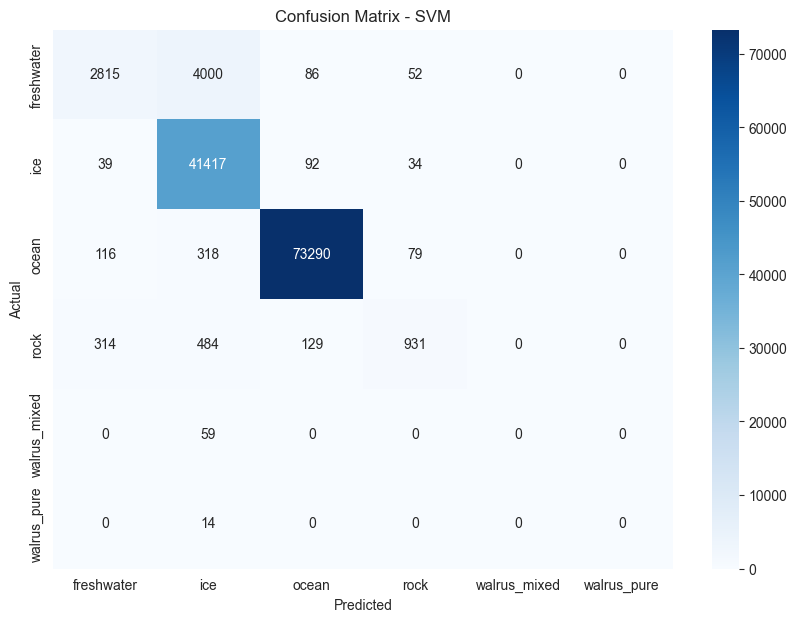

In [8]:
# Plot the confusion matrix for each model
for model_name, result in results.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(result["conf_matrix"], annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

In [9]:
# Plot the Precision-Recall Curve for each model
for model_name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result["model"].predict_proba(X_test)[:, 1])
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.show()


ValueError: multiclass format is not supported

In [ ]:
# Visual inspection of some prediction results
for image_path, (general_shapefile, walrus_shapefile) in list(file_pairs.items())[:5]:  # Limit to first 5 images for inspection
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    for model_name, result in results.items():
        predicted_image = np.zeros((src.height, src.width), dtype=np.uint8)
        for row in range(src.height):
            for col in range(src.width):
                pixel = image[:, row, col].reshape(1, -1)
                predicted_label = result["model"].predict(pixel)
                predicted_image[row, col] = predicted_label

        unique_labels = np.unique(predicted_image)
        plt.figure(figsize=(10, 10))
        plt.title(f"Predicted classes for {os.path.basename(image_path)} with {model_name}")
        plt.imshow(predicted_image, cmap='tab10', vmin=0, vmax=len(le.classes_)-1)
        
        # Create a color bar with fixed labels
        cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
        cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
        
        # Highlight the labels present in the current image
        present_labels = [le.classes_[i] for i in unique_labels]
        print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
        
        plt.show()
